In [6]:
from imutils import face_utils
import numpy as np
import imutils
import argparse
import dlib
import cv2
import random
from PIL import Image
# import the necessary packages
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import argparse
import imutils
import dlib
import cv2
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
from skimage.feature import hog

choose_path_delimiter = 0
# linux = 1
# windows = 0
if choose_path_delimiter == 1:
    path_delimiter = '/'
else:
    path_delimiter ='\\'

%matplotlib inline

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--shape-predictor", required=True,help="path to facial landmark predictor")
#%tb ap.add_argument("-i", "--image", required=True,help="path to input image")
#%tb args = vars(ap.parse_args())



## Face Align function to align any facial image and crop the face region

In [7]:
#%matplotlib inline
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=256)

# Face Align Function
def faceAlign(image):
    #image = mpimg.imread(img)
    image = imutils.resize(image, width=800)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 2)
    faceAligned = []
    for rect in rects:
        faceAligned = fa.align(image, gray, rect)
        #print(rect)
        #plt.imshow(faceAligned)
    
    return faceAligned


image = mpimg.imread('dataset_cropped/Denise Richards/DeniseRichards471.jpg')
#plt.imshow(image)
#plt.imshow(faceAlign(image))

image = faceAlign(image)


##  Sample Image used for the shape

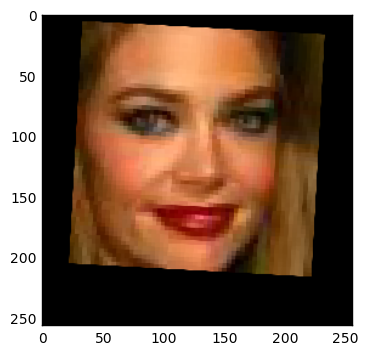

In [8]:
image = mpimg.imread('dataset_cropped/Denise Richards/DeniseRichards471.jpg')

image = faceAlign(image)
plt.imshow(image)

## Function to list files in directories and subdirectories
 Used for listing all  images in a folder 

In [18]:
import os                                                                                                             

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r  


In [ ]:
sample_length = 15
image_paths=list_files('dataset_cropped')
sample_dt=random.sample(image_paths,int(sample_length))
images,labels=read_images(sample_dt)

## Label encoder to convert label strings to numbers

In [10]:
# Finding unique labesl and encoding them

all_labels = [imag.split(path_delimiter)[-2] for imag in image_paths]

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(all_labels)
labels_enc = le.transform(all_labels)

In [11]:
unique_labels = list(le.classes_)
print(unique_labels)
print(le.transform(unique_labels))

['Abhishek Bachan', 'Alex Rodriguez', 'Ali Landry', 'Alyssa Milano', 'Anderson Cooper', 'Anna Paquin', 'Audrey Tautou', 'Barack Obama', 'Ben Stiller', 'Christina Ricci', 'Clive Owen', 'Cristiano Ronaldo', 'Daniel Craig', 'Danny Devito', 'David Duchovny', 'Denise Richards', 'Diane Sawyer']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


## Aligning images and saving them in 'dataset_aligned' folder

In [5]:
# Saving Aligned faces to see if keras is faster
for img_path in image_paths:
    try:
        image = faceAlign(mpimg.imread(img_path));
    except:
        continue
    folder = img_path.split(path_delimiter)[-2]
    filename = img_path.split(path_delimiter)[-1]
    
    if image is not None and np.shape(np.shape(image)) == (3, ):
        if not os.path.exists('dataset_aligned/'+folder): os.makedirs('dataset_aligned/'+folder)
        cv2.imwrite(("dataset_aligned/{}/{}.jpg".format(folder,filename)),image)    

## Function to read aligned images and append the image as well as the label

In [12]:
# read_images fnc for data_aligned images folder
def read_images_align(image_paths):
    images = [];
    labels = [];
    for img_path in image_paths:
        image = mpimg.imread(img_path)
        images.append(image)
        labels.append(img_path.split(path_delimiter)[1])
    return images,labels

## Function to read as well as align. 
 Makes the CNN model slow as a result

In [13]:
# for data_cropped folder

from tqdm import tqdm

def read_images(image_paths):
    images = [];
    labels = [];
    for img_path in image_paths:
        try:
            image = faceAlign(mpimg.imread(img_path));
        except:
            continue
        if image is not None and np.shape(np.shape(image)) == (3, ):
            images.append(image)
            labels.append(img_path.split(path_delimiter)[1])
    return images,labels

## Data generator function for CNN

In [45]:
def data_gen(batch_size=30):
    while True:
        
        image_paths=list_files('dataset_aligned')
        sample_dt=random.sample(image_paths,int(batch_size)+10)
        #print('step1')
        images,labels=read_images_align(sample_dt)
        images=np.asarray(images)
        labels=np.asarray(labels)
        
        
        
        flipped_img=[];
        blur_grays = [];
        for image in images:
            gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
            gray = cv2.equalizeHist(gray)
            kernel_size = 7 # Must be an odd number (3, 5, 7...)
            blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
            blur_grays.append(blur_gray)
            flipped_img.append(np.fliplr(blur_gray))
        
        blur_grays = np.append(blur_grays , flipped_img, axis = 0)
        labels = np.append(labels, labels , axis=0)
        
        #labels = np.dstack((labels,labels))
        ind = np.random.choice(blur_grays.shape[0], batch_size, replace=False)
        blur_grays=blur_grays[ind,:,:]
        labels=le.transform(labels[ind])
        blur_grays = np.reshape(blur_grays, [-1,1,256,256])
        X=blur_grays
        y=labels        
        
        #print(np.shape(blur_grays),np.shape(flipped_img))
        y = np.reshape(y, [ -1,1])
        
        yield X,y

### Sample of processing images

In [46]:
sample_images,sample_labels = next(data_gen(10))


In [47]:
np.shape(sample_images)

(10, 1, 256, 256)

(1, 256, 256)
(256, 256)
[14]


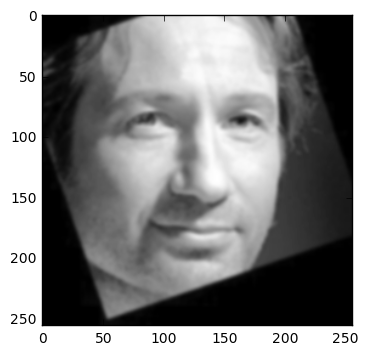

In [48]:
sample_choice = random.randint(0,9)
sample_img = sample_images[sample_choice]
print(np.shape(sample_img))
sample_img = np.reshape(sample_img,[256,256])
print(np.shape(sample_img))
plt.imshow(sample_img, cmap = 'gray')
print(sample_labels[sample_choice])

# Converting image to from mpimg RGB to BGR( which cv2 considers as RGB sequence)
#sample_img = cv2.cvtColor(cv2.flip(sample_img,1), cv2.COLOR_BGR2RGB)

## Image Feature Exploration

### Color Exploration

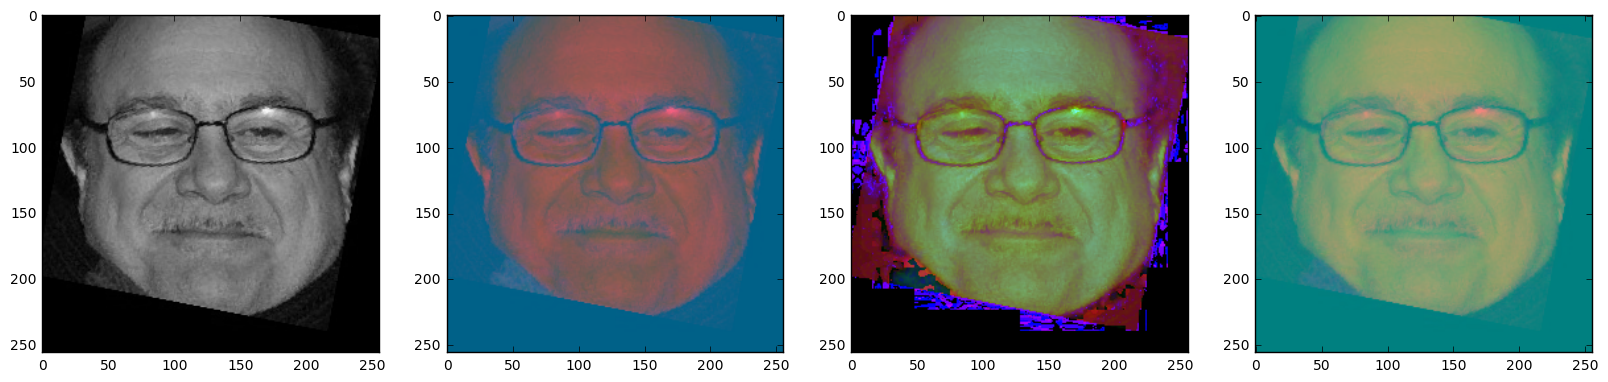

In [245]:
fig = plt.figure(figsize=[20,10])
plt.subplot(241)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY),cmap='gray')

plt.subplot(242)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_RGB2LUV))

plt.subplot(243)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_RGB2HLS))

plt.subplot(244)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2YCrCb))

### HOG Feature Exploration

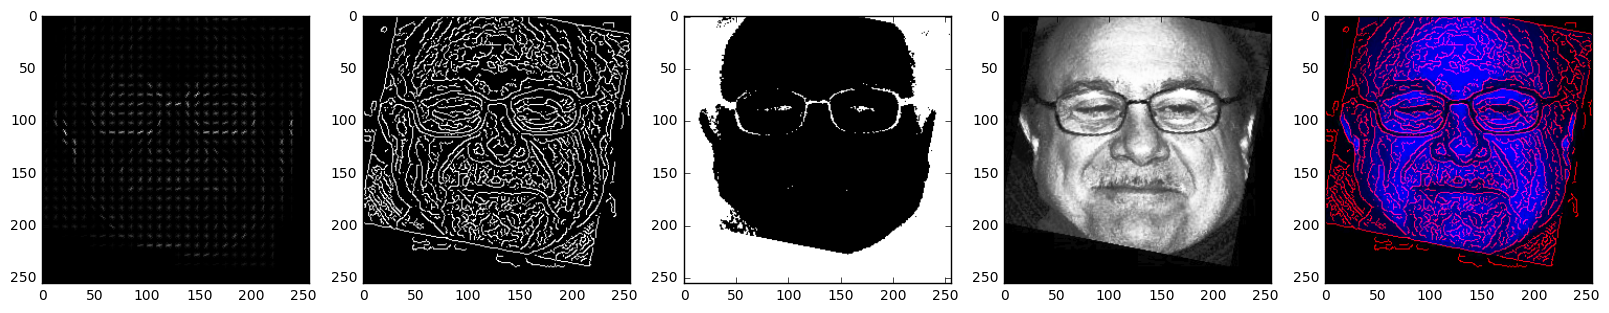

In [297]:



gray = cv2.cvtColor(sample_img,cv2.COLOR_RGB2GRAY)
gray = cv2.equalizeHist(gray)
kernel_size = 7 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 1
high_threshold = 20
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


features , hog_img = hog(gray, orientations=9, 
    pixels_per_cell=(9, 9),
    cells_per_block=(5, 5), 
    transform_sqrt=False, 
    visualise=True, feature_vector=True)



fig = plt.figure(figsize=[20,10])
plt.subplot(251)
plt.imshow(hog_img, cmap =  'gray')

plt.subplot(252)
plt.imshow(edges, cmap = 'Greys_r')

plt.subplot(253)
plt.imshow(gray<60, cmap = 'gray')

plt.subplot(254)
plt.imshow(gray, cmap = 'gray')


img2 = np.zeros_like(sample_img)
img2[:,:,0] = edges
img2[:,:,1] = hog_img
img2[:,:,2] = gray

plt.subplot(255)
plt.imshow(img2)

# note to self ... use equalizeHist function for grayscale images

In [298]:
# Function to create a feature image and feed to CNN

def process_img(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    
    kernel_size = 7 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    low_threshold = 1
    high_threshold = 20
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    features , hog_img = hog(gray, orientations=9, 
    pixels_per_cell=(9, 9),
    cells_per_block=(7,7), 
    transform_sqrt=False, 
    visualise=True, feature_vector=True)
    
    img2 = np.zeros_like(sample_img)
    img2[:,:,0] = edges
    img2[:,:,1] = hog_img
    img2[:,:,2] = gray
    
    return img2

In [299]:
ima=process_img(sample_img)

## Baseline Alexnet model

In [429]:
# Alexnet
num_classes =17
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD



input_shape=(sample_img.shape[0],sample_img.shape[1],1)

model_base = Sequential()
model_base.add(Conv2D( nb_row=11,nb_col = 11, activation="relu", nb_filter=48, subsample=(4, 4), input_shape=input_shape))
model_base.add(Dropout(0.25))


model_base.add(Conv2D( subsample=(2, 2), nb_row=5, nb_col= 5, activation="relu", nb_filter=128))
model_base.add(Dropout(0.25))
model_base.add(MaxPooling2D(pool_size=(2, 2)))

model_base.add(Conv2D( nb_row=3,nb_col= 3, activation="relu", nb_filter=192, border_mode="same", subsample=(2, 2)))
model_base.add(Dropout(0.25))
model_base.add(MaxPooling2D(pool_size=(2, 2)))

# Conv layer 4 output shape (13, 13, 192)
model_base.add(Conv2D( border_mode="same", activation="relu", nb_row = 3,nb_col =  3, nb_filter=192))
model_base.add(Dropout(0.25))

# Conv layer 5 output shape (128, 13, 13)
model_base.add(Conv2D( border_mode="same", activation="relu", nb_row=3, nb_col = 3, nb_filter=128))
model_base.add(Dropout(0.25))


model_base.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_base.add(Dense(2048, activation='relu'))
model_base.add(Dropout(0.25))
model_base.add(Dense(2048, activation='relu'))
model_base.add(Dropout(0.25))
model_base.add(Dense(num_classes, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model_base.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
 
print(model.summary())


batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)


model_base.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_38 (Convolution2D) (None, 256, 256, 3)   6           convolution2d_input_10[0][0]     
____________________________________________________________________________________________________
elu_19 (ELU)                     (None, 256, 256, 3)   0           convolution2d_38[0][0]           
____________________________________________________________________________________________________
convolution2d_39 (Convolution2D) (None, 126, 126, 24)  1824        elu_19[0][0]                     
____________________________________________________________________________________________________
elu_20 (ELU)                     (None, 126, 126, 24)  0           convolution2d_39[0][0]           
___________________________________________________________________________________________

C:\Users\anish_4s67ibh\Anaconda2\envs\tensorflow\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2010/2000 [==============================] - 202s - loss: 14.7164 - acc: 0.0866 - val_loss: 12.3572 - val_acc: 0.2333
Epoch 2/4
2010/2000 [==============================] - ETA: 129s - loss: 15.5808 - acc: 0.0333 - ETA: 133s - loss: 15.0436 - acc: 0.0667 - ETA: 129s - loss: 14.5063 - acc: 0.1000 - ETA: 123s - loss: 14.7749 - acc: 0.0833 - ETA: 117s - loss: 14.7212 - acc: 0.0867 - ETA: 115s - loss: 14.4167 - acc: 0.1056 - ETA: 113s - loss: 14.5063 - acc

In [453]:
# Alexnet

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


input_shape=(sample_img.shape[0],sample_img.shape[1],1)

model_base = Sequential()
model_base.add(Conv2D(64, 3, 3, input_shape=input_shape))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))

model_base.add(Conv2D(32, 3, 3))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))

model_base.add(Conv2D(64, 3, 3))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size=(2, 2)))


model_base.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_base.add(Dense(64))
model_base.add(Activation('relu'))
model_base.add(Dropout(0.5))
model_base.add(Dense(17))
model_base.add(Activation('sigmoid'))

model_base.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)


model_base.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

Epoch 1/4
1230/2000 [=================>............] - ETA: 3051s - loss: 5.4321 - acc: 0.0333 - ETA: 1740s - loss: 5.9826 - acc: 0.0500 - ETA: 1307s - loss: 6.4213 - acc: 0.0444 - ETA: 1083s - loss: 6.9705 - acc: 0.0333 - ETA: 948s - loss: 7.8412 - acc: 0.0267  - ETA: 851s - loss: 8.1506 - acc: 0.0278 - ETA: 785s - loss: 8.0582 - acc: 0.0333 - ETA: 730s - loss: 8.1449 - acc: 0.0292

KeyboardInterrupt: 

### Modified ALEXNET Model

In [ ]:
# Modified Alexnet

from keras.models import Sequential
from keras.layers import Flatten,Dense, Lambda
# There was a problem with original Keras progress bar due to which Notebook used to hang.
# Changing the progress bar with another version of it so as to get the code working in Notebook. Look at model.fit command on how its used
#from keras_tqdm import TQDMNotebookCallback 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Activation, Cropping2D, ELU
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

input_shape=(sample_img.shape[0],sample_img.shape[1],1)
model=Sequential()
#model.add(Lambda(lambda x:x/255.0-0.50,input_shape=input_shape))
model.add(Conv2D(3,1,1,subsample=(1,1),border_mode="valid",init='he_normal',input_shape=input_shape))
model.add(ELU())
model.add(Conv2D(24,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(36,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Dropout(.4))
model.add(Conv2D(48,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(Dropout(.3))
model.add(ELU())
model.add(Flatten())
model.add(Dense(1164,init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(.2))
model.add(Dense(100,init='he_normal'))
model.add(ELU())
model.add(Dense(50,init='he_normal'))
model.add(ELU())
model.add(Dense(10,init='he_normal'))
model.add(ELU())
model.add(Dense(17,init='he_normal'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(15)
gen_valid=data_gen(15)


model.fit_generator(gen_train, samples_per_epoch=2500,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25, verbose =2)

Epoch 1/4


C:\Users\anish_4s67ibh\Anaconda2\envs\tensorflow\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


515s - loss: 12.0501 - acc: 0.0579 - val_loss: 11.6168 - val_acc: 0.0333
Epoch 2/4


In [442]:
# Random
nb_classes = 17
model = Sequential()
model.add(Dense(512,input_shape=(sample_img.shape[0],sample_img.shape[1])))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_85 (Dense)                 (None, 256, 512)      131584      dense_input_5[0][0]              
____________________________________________________________________________________________________
activation_61 (Activation)       (None, 256, 512)      0           dense_85[0][0]                   
____________________________________________________________________________________________________
dropout_116 (Dropout)            (None, 256, 512)      0           activation_61[0][0]              
____________________________________________________________________________________________________
dense_86 (Dense)                 (None, 256, 512)      262656      dropout_116[0][0]                
___________________________________________________________________________________________

In [445]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)

model.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

Epoch 1/4


ValueError: Error when checking model target: expected activation_63 to have 3 dimensions, but got array with shape (30, 1)

In [ ]:
model = Sequential()  

# first set of CONV => RELU => POOL  
model.add(Conv2D(20, 5, 5, border_mode="same",  
         input_shape=input_shape))  
model.add(Activation("relu"))  
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  

# second set of CONV => RELU => POOL  
model.add(Conv2D(50, 5, 5, border_mode="same"))  
model.add(Activation("relu"))  
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  

# set of FC => RELU layers  
model.add(Flatten())  
model.add(Dense(500))  
model.add(Activation("relu"))  

# softmax classifier  
model.add(Dense(17))  
model.add(Activation("softmax"))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)


model.fit_generator(gen_train, samples_per_epoch=2000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

Epoch 1/4
 120/2000 [>.............................] - ETA: 7619s - loss: 12.9169 - acc: 0.1333 - ETA: 38988s - loss: 14.5175 - acc: 0.0667 - ETA: 27521s - loss: 14.8719 - acc: 0.0556 - ETA: 20498s - loss: 15.1835 - acc: 0.0417

In [56]:
## New Iteration of CNN https://martinbel.github.io/face-detection.html

from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.pooling import AveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras import optimizers 
from keras.callbacks import ModelCheckpoint, History, Callback
from keras.layers.advanced_activations import PReLU
from keras import initializations
from keras.models import load_model
from keras.optimizers import *

def conv_3x3_2fc_500(size):
    model = Sequential()
    init = 'he_normal'
    # Block 1
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1', 
                            init=init, input_shape=(1, size, size), subsample=(1, 1) ,dim_ordering="th"))
#    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2', init=init))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name='block1_pool'))

    model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1', init=init))
#    model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2', init=init))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name='block2_pool'))

    model.add(Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1', init=init))
#    model.add(Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2', init=init))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name='block3_pool'))

    model.add(Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1', init=init))
#    model.add(Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2', init=init))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name='block4_pool'))
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu', init='he_normal', name='fc1'))
    model.add(Dropout(p=0.5))
    model.add(Dense(500, activation='relu', init='he_normal', name='fc2'))
    model.add(Dropout(p=0.5))
#    model.add(AveragePooling2D(pool_size=(8, 8), strides=None, border_mode='valid', dim_ordering='th'))
    #model.add(Dropout(p=0.5))
    model.add(Dense(17, activation='softmax', name='predictions'))
    
    optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # optim = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

model = conv_3x3_2fc_500(size=256)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
block1_conv1 (Convolution2D)     (None, 64, 256, 256)  640         convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 31, 127, 256)  0           block1_conv1[0][0]               
____________________________________________________________________________________________________
block2_conv1 (Convolution2D)     (None, 31, 127, 128)  295040      block1_pool[0][0]                
____________________________________________________________________________________________________
block2_pool (MaxPooling2D)       (None, 15, 63, 128)   0           block2_conv1[0][0]               
___________________________________________________________________________________________

In [ ]:
batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)

loss_history = History()
model.optimizer.lr.assign(0.0005)
model.fit_generator(gen_train, samples_per_epoch=120,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=25, max_q_size=25)

Epoch 1/4
120/120 [==============================] - ETA: 67s - loss: 15.5808 - acc: 0.0333 - ETA: 43s - loss: 15.0436 - acc: 0.0667 - ETA: 22s - loss: 15.4017 - acc: 0.0444 - 105s - loss: 15.5808 - acc: 0.0333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/4
